In [23]:
%%capture
%pip install neqsim

#To check for methods in a Java object 
#from neqsim import methods

# Experimental data
Experimental data is collected.

In [24]:
import pandas as pd
expdata_df = pd.read_csv('../../../data/thermodynamics/heatcapacity/nitrogen.csv')
expdata_df

expdata_df = expdata_df.loc[expdata_df['Temperature (K)'] < 1300]
expdata_df

,Temperature (K),Specific Heat Capacity (J/(mol*K)),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,100,29.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200,29.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,300,29.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,400,29.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500,29.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,600,30.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,700,30.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,800,31.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,900,32.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1000,32.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 640x480 with 0 Axes>

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


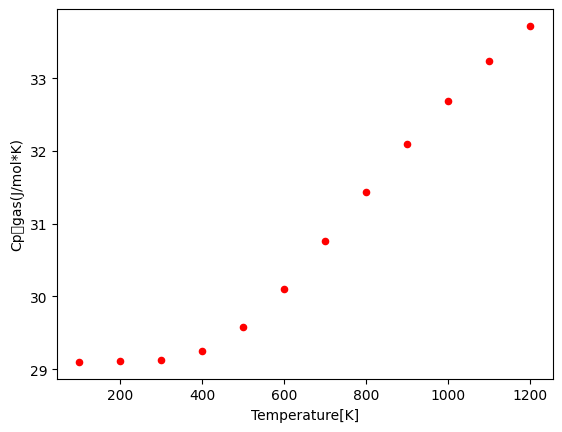

In [25]:
from matplotlib import pyplot as plt
fig = plt.figure()

expdata_df.plot(x='Temperature (K)', y='Specific Heat Capacity (J/(mol*K))', kind='scatter',ylabel='Cp	gas(J/mol*K)', xlabel='Temperature[K]',color='red')

plt.show()

# Evaluation of experimental data

In this section the experimental data will be evaluated and eventual some data sets will be removed from the set.

# Compare to NeqSim Calculations

## NeqSim calculations at 288.15 K

<Figure size 640x480 with 0 Axes>

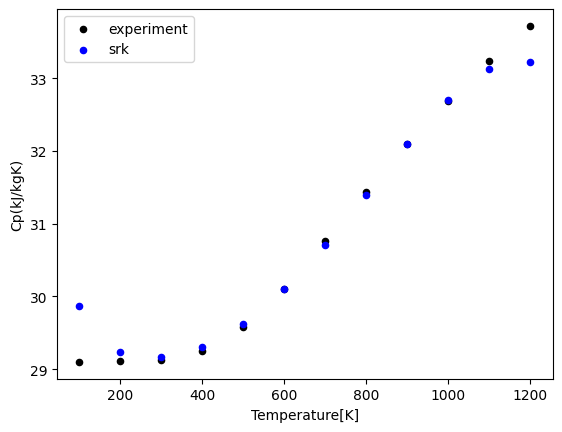

In [26]:
import neqsim
from neqsim.thermo.thermoTools import fluid, TPflash, fluidComposition,bubp
import pandas as pd
import numpy as np

fluid1 = fluid('srk')
fluid1.addComponent('nitrogen', 1.0)
fluid1.setTemperature(15.0, 'C')
fluid1.setPressure(1.0, 'bara')

def heatcap(input):
    fluid1.setTemperature(input[0], 'K')
    TPflash(fluid1)
    fluid1.initProperties()
    return fluid1.getPhase('gas').getCp('J/molK')

temperatures = expdata_df['Temperature (K)'].values.tolist()
expData = expdata_df['Specific Heat Capacity (J/(mol*K))'].values.tolist()
input = zip(temperatures)
cP_res = [heatcap(inp) for inp in input]

dataWithExperiment = expdata_df.assign(cP_res = cP_res)

from matplotlib import pyplot as plt
fig = plt.figure()	
plot1 = dataWithExperiment.plot(x='Temperature (K)', y='Specific Heat Capacity (J/(mol*K))', kind='scatter',ylabel='Cp(kJ/kgK)', xlabel='Temperature[K]',color='black')	
dataWithExperiment.plot(ax=plot1, x='Temperature (K)', y='cP_res', kind='scatter',ylabel='Cp(kJ/kgK)', xlabel='Temperature[K]',color='blue')	
plt.legend(['experiment', 'srk'])
plt.show()

# Parameter fitting

NeqSim Cp calc:
https://github.com/equinor/neqsim/blob/37680eafd43242488f5522fae4e80d50dfd4b3c0/src/main/java/neqsim/thermo/component/Component.java#L1256

 getCpA() + getCpB() * temperature + getCpC() * Math.pow(temperature, 2)
        + getCpD() * Math.pow(temperature, 3) + getCpE() * Math.pow(temperature, 4);

## Manual fitting

In [27]:
CpA = fluid1.getComponent(0).getCpA()
CpB = fluid1.getComponent(0).getCpB()
CpC = fluid1.getComponent(0).getCpC()
CpD = fluid1.getComponent(0).getCpD()
CpE = fluid1.getComponent(0).getCpE()

print('CpA ', CpA)
print('CpB ', CpB)
print('CpC ', CpC)
print('CpD ', CpD)
print('CpE ', CpE)

CpA  29.423246
CpB  -0.002169954
CpC  5.81e-07
CpD  1.31e-08
CpE  -8.23086e-12


[-4.08653846e-12  4.68612406e-09  5.77114899e-06 -3.02604733e-03
  2.93824747e+01]
CpA_fitted 29.3824747474747
CpB_fitted -0.0030260473322971763
CpC_fitted 5.771148989898619e-06
CpD_fitted 4.686124061124461e-09
CpE_fitted -4.086538461538615e-12


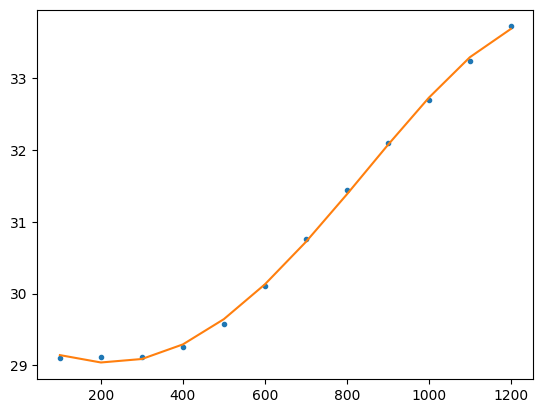

In [28]:
x = np.array(temperatures)
y = np.array(expData)
z = np.polyfit(x, y, 4)
print(z)
p = np.poly1d(z)

print('CpA_fitted', p[0])
print('CpB_fitted', p[1])
print('CpC_fitted', p[2])
print('CpD_fitted', p[3])
print('CpE_fitted', p[4])

xp = np.linspace(-2, 6, 100)
plt.plot(x, y, '.', x, p(x), '-')

## Automatic fitting